# La Stratégie CPPI ainsi qu'une amélioration

**Professeur** : Sylvain CHAMPONNOIS 

**Etudiants** : Nabil LAHMER et Milan HUANG

# Importation des packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import openpyxl as xls
from datetime import datetime
from tool_cppi import *
from tool_stat import *

***ReadMe***:
- Les fonctions et classes sont toutes sur les modules **tool_cppi** et **tool_stat**.
- Plus de détail sur le rapport. 
- Utiliser la fonction **createxls(df, True)** si vous voulez plus de détail sur une DataFrame, cela va crée un fichier excel ayant tous les détails, sur le folder "**01. Excel Data**".

# Importation des Données

**A savoir** : Comme énoncé dans le rapport, les figures sont données de manière flexible. Autrement dit, les données peuvent être différentes. Nous allons en proposer 1 **actif risqué** unique (L'***EUROSTOXX600***) et 3 **actifs sans-risques** qui sont: 
- Un taux fixe à 2% (généré grâce à la fonction ***Bond*** du module **tool_cppi.py**
- L'indice ***EONIA***,
- L'indice ***FED***.

In [2]:
link = os.getcwd()
folder = glob.glob('*')
data_link = link + "\\data.csv"
bank = link + "\\decision.csv"
fed1_link = link + "\\FED1.csv"
fed2_link = link + "\\FED2.csv"

In [3]:
print(link)

C:\Users\milan\OneDrive\Bureau\Projet


In [4]:
data = pd.read_csv(data_link, index_col = "Dates", sep = ";", parse_dates = True)
base_pred = pd.read_csv(bank, index_col = "date", sep = ",", parse_dates = True)
fed1 = pd.read_csv(fed1_link, index_col = "DATE", sep = ",", parse_dates = True) # 1980's-1999
fed1.rename(columns={fed1.columns[0]:"FED"}, inplace=True)
fed2 = pd.read_csv(fed2_link, index_col = "Date", sep = ",", parse_dates = True) # 1990 - 2023
fed2.rename(columns={fed2.columns[0]:"FED"}, inplace=True)
risk = pd.DataFrame(data["SXXR Index"])
rate = pd.DataFrame(data["EONIA Index"])

In [5]:
# Réunification des deux indices FED
fed = pd.concat([fed1,fed2],axis = 0)
fed = fed.reindex(data.index, fill_value=pd.NA)

# Préparation des données

Nous allons mettre élargir les indices concernant les décisions de la Banque Centrale, tels que ***base_pred*** ait les mêmes index que ***data***. Lorsque la Banque Centrale :
- Enonce une ***Baisse des taux***, la donnée indique -1,
- Enonce une ***Hausse des taux***, la donnée indique +1,
- Enonce une information non-significative, ou n'énonce aucune information, la donnée indique 0.
Cette donnée a été générée par mon partenaire de groupe, en utilisant du **NLP** 

In [6]:
base_pred = base_pred.reindex(data.index, fill_value = 0)
print(all(fed.index==base_pred.index))

True


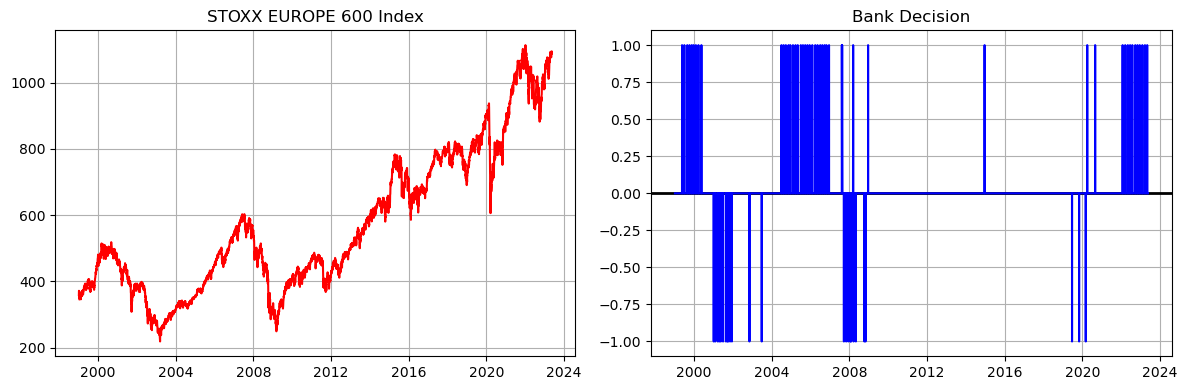

In [7]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(risk, c = "r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(base_pred, c = "blue")
ax2.set_title('Bank Decision')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

# Cas 1 - CPPI de base

Nous allons utiliser un taux fixe à 2% que l'on va générer tel que les données auront les mêmes index que **rate**. Voici les paramètres utilisés pour cette première analyse:
- Actif risqué : EUROSTOXX600,
- Actif non-risqué : Taux fixe 2%,
- Investissement initial : 100€,
- Capital garanti : 95%,
- Date d'investissement : 2007,
- Horizon : 5 ans,
- Multiple : 4.


In [8]:
rate2 = bond(df = rate, r = 2, naming = "Fixed")
rate2

,Fixed
Dates,
1999-01-04,2
1999-01-05,2
1999-01-06,2
1999-01-07,2
1999-01-08,2
...,...
2023-05-10,2
2023-05-11,2
2023-05-12,2


<AxesSubplot:>

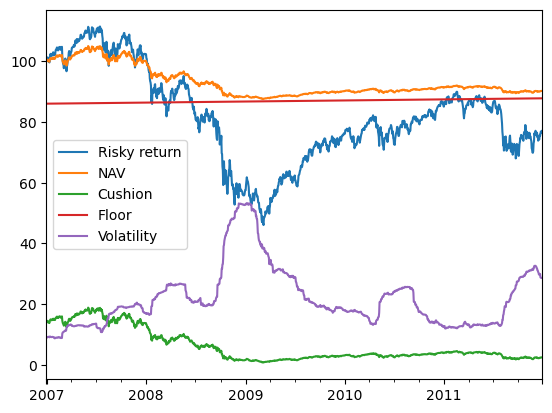

In [9]:
cppi2007_2 = Central_CPPI(dfrisk=risk, dfrate=rate2, 
                 initial_investment=100.0, garant=0.95, y0="2007",
                 horizon=5, multiplier=3, activation=[], decision = base_pred)
information2007_2 = cppi2007_2.cppi(vol_opt=False, multi_opt=False)
crucial2007_2 = cppi2007_2.crucial(opt = False, vol_opt = False, multi_opt=False)
crucial2007_2.plot()

In [10]:
df_analysis_2007_2 = pd.DataFrame(crucial2007_2["NAV"])
stat = StatCPPI(df=df_analysis_2007_2, dfrisk = risk, dfriskless=rate2)
stat.summary()

,Fund,Risky Asset
Return's Mean (%),-0.008259,-0.007486
Ann. Volatility (%),4.348184,24.486093
Var. Coeff. (%),5.209885,18.748314
Ann. Return (%),-2.029315,-5.075942
MaxDrawDown (%),-16.611999,-58.689846
Sharpe Ratio,-0.009267,-0.016273
VaR 5%,-0.004300,-0.024858
Exp. Shortfall,-0.007287,-0.036780
Semi Deviation (%),0.300407,1.584666


# Cas 2 - Fenetre Glissante

Notre première amélioration se situe sur le niveau de Garantie qui est en lien direct avec le Plancher. Cette amélioration se situe sur le paramètre **activation = [a,b,...]** où à l'intérieur des crochets, représente les mois de l'année. Par exemple si **activation = [1]**, alors la garantie se réinitialise tous les Janvier. Cette garantie va prendre en valeur la dernière valeur liquidative, permettant d'impacté le plancher (avec un facteur d'actualisation). Son avantage est de pouvoir donner plus de poids au coussin, au cas où il est devenu faible trop rapidement ou à l'issu de l'ensemble des années d'investissement.


Nous allons utiliser le **taux EONIA** que l'on a importé. Ce cas de figure va être divisé en deux parties : 
- Une garantie haute,
- Une garantie moins élevée.


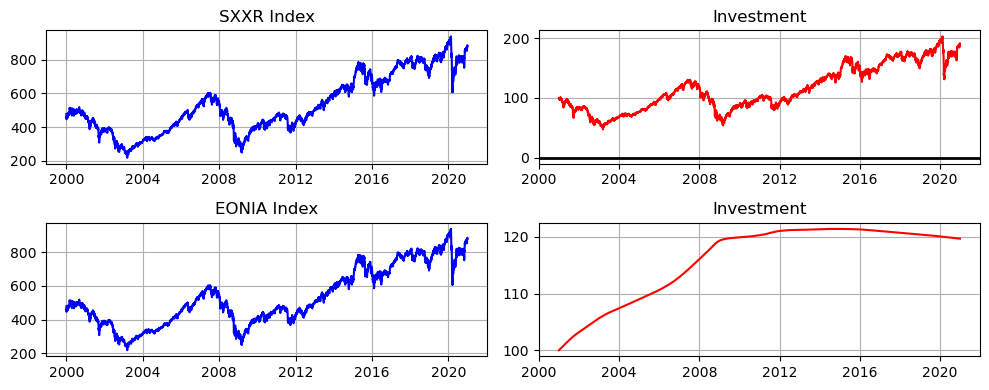

In [11]:
investment = returns(risk,100,2001,20,2000)
monnaie = monetarize(rate, 100, 2001, 20,2000)

# Création de la figure et des sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))

# Tracé des graphiques à gauche
ax1.plot(risk["2000":"2020"], c="b")
ax1.set_title('SXXR Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(investment["2000":"2020"],c="r")
ax2.set_title('Investment')
ax2.grid(True)

# Tracé des graphiques à gauche
ax3.plot(risk["2000":"2020"], c="b")
ax3.set_title('EONIA Index')
ax3.grid(True)

ax4.plot(monnaie["2000":"2020"],c="r")
ax4.set_title('Investment')
ax4.grid(True)



# Affichage de la figure
plt.tight_layout()
plt.show()


**Garantie élevée : 95%**

Voici les paramètres utilisés pour cette analyse:
- Actif risqué : EUROSTOXX600,
- Actif non-risqué : Taux EONIA,
- Investissement initial : 100€,
- Capital garanti : 95%,
- Date d'investissement : 2017,
- Horizon : 5 ans,
- Multiple : 5.
- Réinitialisation des Planchers : Janvier

<AxesSubplot:>

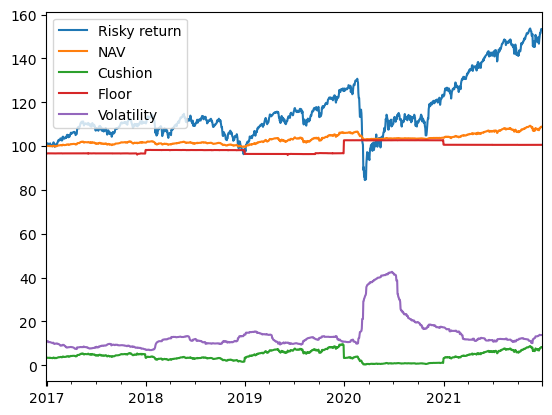

In [12]:
cppi2017_eonia = Central_CPPI(dfrisk=risk, dfrate=rate, 
                 initial_investment=100.0, garant=0.95, y0="2017",
                 horizon=5, multiplier=5, activation=[1], decision = base_pred)
information2017_eonia = cppi2017_eonia.cppi(vol_opt=False, multi_opt=False)
crucial2017_eonia = cppi2017_eonia.crucial(opt = False, vol_opt = False, multi_opt=False)
crucial2017_eonia.plot()

**Garantie basse : 80%**

Voici les paramètres utilisés pour cette analyse:
- Actif risqué : EUROSTOXX600,
- Actif non-risqué : Taux EONIA,
- Investissement initial : 100€,
- Capital garanti : 80%,
- Date d'investissement : 2017,
- Horizon : 5 ans,
- Multiple : 5.
- Réinitialisation des Planchers : Janvier

<AxesSubplot:>

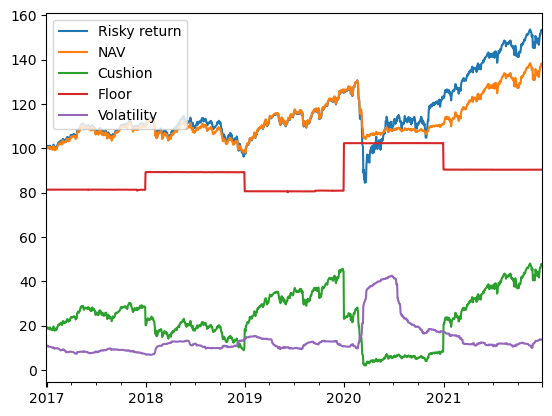

In [13]:
cppi2017_eonia = Central_CPPI(dfrisk=risk, dfrate=rate, 
                 initial_investment=100.0, garant=0.8, y0="2017",
                 horizon=5, multiplier=5, activation=[1], decision = base_pred)
information2017_eonia = cppi2017_eonia.cppi(vol_opt=False, multi_opt=False)
crucial2017_eonia = cppi2017_eonia.crucial(opt = False, vol_opt = False, multi_opt=False)
crucial2017_eonia.plot()

In [14]:
df_analysis_2017_eonia = pd.DataFrame(crucial2017_eonia["NAV"])
stat2017 = StatCPPI(df=df_analysis_2017_eonia, dfrisk = risk, dfriskless=rate)
stat2017.summary()

,Fund,Risky Asset
Return's Mean (%),0.037671,0.026814
Ann. Volatility (%),10.469476,16.063535
Var. Coeff. (%),8.109041,11.826597
Ann. Return (%),6.657523,8.904485
MaxDrawDown (%),-20.087140,-35.362810
Sharpe Ratio,0.006751,0.008898
VaR 5%,-0.010406,-0.013837
Exp. Shortfall,-0.016670,-0.025042
Semi Deviation (%),0.733243,1.135422


# Cas 3 - Multiple variable en fonction de la volatilité

Cette amélioration consiste à guider le Multiple en fonction de la Volatilité. Nous avons 

Voici les paramètres utilisés pour cette analyse:
- Actif risqué : EUROSTOXX600,
- Actif non-risqué : Taux EONIA,
- Investissement initial : 100€,
- Capital garanti : 90%,
- Date d'investissement : 2004,
- Horizon : 6 ans,
- Multiple : 3 (Qui n'auront aucune impacte dans ce cas, vu que **vol_opt** est activée).
- Guide du multiple par la volatilité : Activée
- Réinitialisation des Planchers : Janvier et Juillet


<AxesSubplot:>

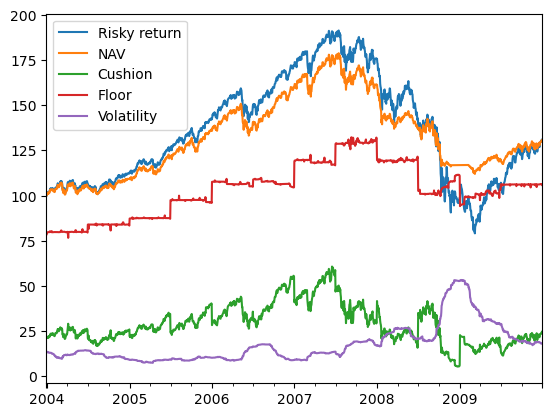

In [15]:
cppi2004_eonia = Central_CPPI(dfrisk=risk, dfrate=rate, 
                 initial_investment=100.0, garant=0.90, y0="2004",
                 horizon=6, multiplier=3, activation=[1,7], decision = base_pred)
information2004_eonia = cppi2004_eonia.cppi(vol_opt=True, multi_opt=False)
crucial2004_eonia = cppi2004_eonia.crucial(opt = False, vol_opt = True, multi_opt=False)
crucial2004_eonia.plot()

In [16]:
df_analysis_2004_eonia = pd.DataFrame(crucial2004_eonia["NAV"])
stat2004 = StatCPPI(df=df_analysis_2004_eonia, dfrisk = risk, dfriskless=rate)
stat2004.summary()

,Fund,Risky Asset
Return's Mean (%),0.025469,0.019925
Ann. Volatility (%),12.217101,20.614160
Var. Coeff. (%),15.967203,21.043642
Ann. Return (%),4.543601,4.587889
MaxDrawDown (%),-37.380060,-58.689846
Sharpe Ratio,0.001616,0.001652
VaR 5%,-0.012909,-0.019586
Exp. Shortfall,-0.019169,-0.031736
Semi Deviation (%),0.851631,1.362738


# Cas 4 - Prise en compte des décision de la Banque Centrale

Comme indiqué plus haut, les décisions de la banque centrale américaine va renvoyer un sorte de **signal** sur la DataFrame **base_pred**. Les signaux $y \in \{-1,0,+1\}$ tels que : 
- -1 indique que la Banque Centrale a annoncé une baisse des taux,
- +1 indique que la Banque centrale a annoncé la hausse des taux,
- 0 La Banque Centrale maintient les taux, ou n'a rien annoncé.


Ces signaux nous permettrait d'améliorer nos stratégies CPPI en plus de l'amélioration de :
- La fenêtre glissante,
- La variable du multiple en fonction de la volatilité.


Tout comme la dernière amélioration (cas 3), nous allons guider le multiple en fonction des signaux :
- Nous ajoutons 50% au multiple si les signaux sont faibles,
- Nous retranchons 50% au multiple si les signaux sont élevé.


Les raisons ont été décrites sur le rapport, et également sur le module **tool_cppi** en commentaire.

Voici les paramètres utilisés pour cette analyse:
- Actif risqué : EUROSTOXX600,
- Actif non-risqué : Taux EONIA,
- Investissement initial : 100€,
- Capital garanti : 80%,
- Date d'investissement : 2004,
- Horizon : 6 ans,
- Multiple : 3 (Qui n'auront aucune impacte dans ce cas, vu que **vol_opt** est activée).
- Guide du multiple par la volatilité : Activée
- Guide du multiple en fonction des décisions de la Banque Centrale 
- Réinitialisation des Planchers : Janvier et Juillet

<AxesSubplot:>

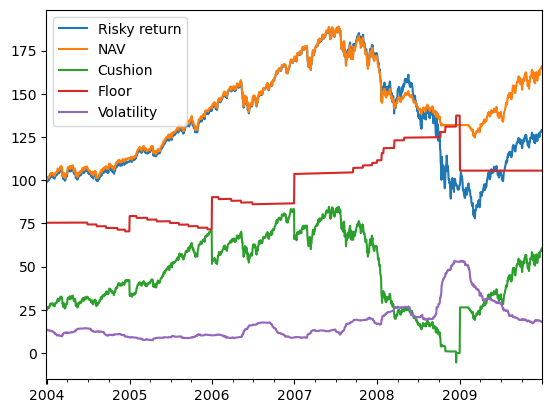

In [17]:
cppi2004_fed = Central_CPPI(dfrisk=risk, dfrate=fed, 
                 initial_investment=100.0, garant=0.80, y0="2004",
                 horizon=6, multiplier=3, activation=[1], decision = base_pred)
information2004_fed = cppi2004_fed.cppi(vol_opt=True, multi_opt=True)
crucial2004_fed = cppi2004_fed.crucial(opt = True, vol_opt = True, multi_opt=True)
crucial2004_fed.plot()

In [18]:
df_analysis_2004_fed = pd.DataFrame(crucial2004_fed["NAV"])
stat2004fed = StatCPPI(df=df_analysis_2004_fed, dfrisk = risk, dfriskless=rate)
stat2004fed.summary()

,Fund,Risky Asset
Return's Mean (%),0.025469,0.035536
Ann. Volatility (%),12.903866,20.614160
Var. Coeff. (%),16.605198,21.043642
Ann. Return (%),8.797282,4.587889
MaxDrawDown (%),-34.041208,-58.689846
Sharpe Ratio,0.004826,0.001564
VaR 5%,-0.013084,-0.019586
Exp. Shortfall,-0.019669,-0.031736
Semi Deviation (%),0.878290,1.362738
